<a href="https://colab.research.google.com/github/lovezoyaxu/car-following-model-in-mixtraffic/blob/main/mixtraffic_GAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

get idea from:https://github.com/boyu-ai/Hands-on-RL

In [ ]:
import gym
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import scipy.io as sio

### **Get data**

download data

HV follow AV

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_av_test_data.mat --output-document=testSet.mat

# load training data
train = sio.loadmat('trainSet.mat')['calibrationData'][:, 0]
test = sio.loadmat(f'testSet.mat')['validationData'][:, 0]

# variable for the columns are [space, svSpd, relSpd, lvSpd], time interval is 0.1 seconds.
# speed in m/s, space in m.
train.shape, test.shape

--2024-05-13 06:54:12--  https://raw.githubusercontent.com/MeixinZhu/Velocity_control/master/trainSet.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6852673 (6.5M) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>]   6.54M  --.-KB/s    in 0.1s    

2024-05-13 06:54:13 (56.5 MB/s) - ‘trainSet.mat’ saved [6852673/6852673]

--2024-05-13 06:54:13--  https://raw.githubusercontent.com/MeixinZhu/Velocity_control/master/testSet.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29889

((938,), (403,))

HV follow HV

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat --output-document=testSet.mat

# load training data
train = sio.loadmat('trainSet.mat')['calibrationData'][:, 0]
test = sio.loadmat(f'testSet.mat')['validationData'][:, 0]

# variable for the columns are [space, svSpd, relSpd, lvSpd], time interval is 0.1 seconds.
# speed in m/s, space in m.
train.shape, test.shape

--2024-05-16 07:48:54--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111996 (2.0M) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>]   2.01M  --.-KB/s    in 0.09s   

2024-05-16 07:48:54 (22.7 MB/s) - ‘trainSet.mat’ saved [2111996/2111996]

--2024-05-16 07:48:54--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conne

((409,), (113,))

Restrictions regarding car following

In [ ]:
ACC_LIMIT = 3 # the limit of acceleration, this can be calibrated based on the data
Ts = 0.1 # time interval for data sampling

### **GYM**

In [ ]:
from gym.spaces import Box
from copy import deepcopy

class CarFolEnv(gym.Env):
    def __init__(self, split = 'train', his_horizon = 10, collision_penalty = 1000):
        """
        split: train or test dataset to use
        his_horizon: number of time steps for history buffer
        collision_penalty: reward penalty if there is a collision
        """
        self.his_horizon = his_horizon  #Take ten data input together is better than a number, there is a certain time sequence
        self.collision_penalty = collision_penalty
        self.split = split

        # Define obs and action space Used to enter the state and action dimensions for subsequent training
        self.observation_space = Box(low = -np.inf, high = np.inf, shape = (3*self.his_horizon,), dtype = np.float32)
        self.action_space = Box(low = -1, high = 1, shape = (1,), dtype = np.float32)

    def reset(self):
        # Randomly select an event from the datset
        if self.split == 'train':
            self.data = random.choice(train)
            #self.data = train[0]
        elif self.split == 'test':
            self.data = random.choice(test)
            #self.data = test[0]

        self.lv_spd = self.data[:, -1]
        self.frame = self.his_horizon # Frame starting from 1

        self.sim_data = deepcopy(self.data[:, :-1])

        # Input data for policy network, considering hisotry buffer
        obs = self.sim_data[self.frame - self.his_horizon:self.frame].flatten() #

        return obs #The space, svSpd, relSpd data from lines 0 to 9 of a sample in train data also put them in a row
        # Mainly to find the initial state of the new trajectory

    def step(self, action):
        # TODO: Finish the car step function
        # Given an acceleration, update car-following states

        # Current simulated state
        spacing, sv_spd, rel_spd = self.sim_data[self.frame - 1]

        # Increase frame count
        self.frame += 1

        acceleration = action[0]

        # Udpate state based on newton equation
        sv_spd_ = max(0.001, sv_spd+acceleration*Ts)
        rel_spd_ = self.lv_spd[self.frame - 1] - sv_spd_
        spacing_ = spacing + Ts*(rel_spd + rel_spd_)/2

        # Update sim_data
        self.sim_data[self.frame -1] = np.asarray([spacing_, sv_spd_, rel_spd_])
        obs = self.sim_data[self.frame - self.his_horizon:self.frame].flatten()

        is_collision = True if spacing_ <= 0 else False
        if is_collision or self.frame == len(self.data):
          done = True
        else:
          done = False

        # Calculating reward information
        sv_spd_gt = self.data[self.frame - 1,1]
        r = -np.log(np.abs(sv_spd_gt - sv_spd_)/sv_spd_gt) - is_collision*self.collision_penalty
        info = {}

        return obs, r, done, info



### **Find expert data from the dataset**


In [ ]:
class GetExpData():
    def __init__(self, split = 'train', his_horizon = 10, max_len = 141):
        self.his_horizon = his_horizon
        self.split = split
        self.max_len = max_len
        if self.split == 'train':
            self.data = random.choice(train)
        elif self.split == 'test':
            self.data = random.choice(test)


    #def __getitem__(self, idx: int):
    def gen_exp(self):
        event = self.data

        self.acc_label = np.diff(event[:, 1])/Ts # acc
        self.state_data = event[:-1, :-1]
        self.segment = self.his_horizon

        obs_state = []
        obs_action = []

        for epoch in range(len(self.acc_label)-10):
            state_link = self.state_data[self.segment - self.his_horizon:self.segment].flatten()
            action_link = self.acc_label[self.segment-1]


            obs_state.append(state_link)
            obs_action.append(action_link)

            self.segment += 1

        return obs_state, obs_action


### *PPO as a generator*

get advantage & for returen figure filter

In [ ]:
from tqdm import tqdm
import collections


def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [ ]:

class PolicyNetContinuous(torch.nn.Module):

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class PPO:

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device):

        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())

        old_log_probs = action_dists.log_prob(actions)


        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage

            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))

            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()



### **GAIL**

Firstly, the discriminator model is implemented. The model architecture is a two-layer fully connected network. The input of the model is a state action pair and the output is a probability scalar.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

The next step is to formally implement the GAIL code. In each iteration, the policies in GAIL interact with the environment, sampling new pairs of state actions. Based on the expert data and the newly sampled data of the strategy, the discriminator is trained first, and then the output of the discriminator is converted into the reward signal of the strategy, and the strategy is trained by PPO algorithm.

In [ ]:
class GAIL:
    def __init__(self, agent, state_dim, action_dim, hidden_dim, lr_d):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent

    def learn(self, expert_s, expert_a, agent_s, agent_a, next_s, dones):
        expert_states = torch.tensor(expert_s, dtype=torch.float).to(device)
        expert_actions = torch.tensor(expert_a, dtype=torch.float).to(device)
        agent_states = torch.tensor(agent_s, dtype=torch.float).to(device)
        agent_actions = torch.tensor(agent_a, dtype=torch.float).to(device)

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)
        discriminator_loss = nn.BCELoss()(agent_prob, torch.ones_like(agent_prob)) + nn.BCELoss()(expert_prob, torch.zeros_like(expert_prob))

        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)




### **training**

In [ ]:
actor_lr = 1e-6
critic_lr = 1e-5
num_episodes = 250
hidden_dim = 896
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


env = CarFolEnv()
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


lr_d = 1e-3
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)
gail = GAIL(agent, state_dim, action_dim, hidden_dim, lr_d)
n_episode = 1500
return_list = []



best_reward = -1000000
model_type = 'actor'
his_horizon = 10
save = f'{model_type}_horizon{his_horizon}.pt'


with tqdm(total=n_episode, desc="Progress bar") as pbar:
    for i in range(n_episode):
        episode_return = 0
        state = env.reset()
        done = False
        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        exp_dataset = GetExpData('train')
        expert_s, expert_a = exp_dataset.gen_exp()

        expert_s = [[float(x) for x in sublist] for sublist in expert_s]
        expert_a = [[x] for x in expert_a]

        gail.learn(expert_s, expert_a, state_list, action_list, next_state_list, done_list)

        #Save the optimal agent model
        if i > 1000:
          if best_reward == -1000000 or best_reward < episode_return:
              best_reward = episode_return

              # save the best model
              with open(save, 'wb') as f:
                  torch.save(agent, f)

        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)


print(best_reward)

### **The results of the training**

In [ ]:
iteration_list = list(range(len(return_list)))
plt.plot(iteration_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('GAIL on {}'.format(CarFolEnv))
plt.title('GAIL on CarFolEnv')


mv_return = moving_average(return_list, 21)
plt.plot(iteration_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('GAIL on CarFolEnv')
plt.show()

### **Test agent performance**

In [ ]:
# Load the best model saved
with open(f'{save}', 'rb') as f:
    test_agent = torch.load(f)

env = CarFolEnv(split = 'test')

transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }

obs = env.reset()
done = False
while not done:
    action = test_agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    transition_dict['states'].append(state)
    transition_dict['actions'].append(action)
    transition_dict['next_states'].append(next_state)
    transition_dict['rewards'].append(reward)
    transition_dict['dones'].append(done)
    state = next_state
    if done == True: #done is the end of a path, it's time for the next path
        break
actions = transition_dict['actions']
print(actions)


[[-0.6899957656860352], [0.08234521746635437], [0.5691064596176147], [-0.24841147661209106], [0.6083546280860901], [-1.2769960165023804], [0.11977452039718628], [1.638733983039856], [0.21410885453224182], [0.6406450867652893], [-0.02854016423225403], [-0.08928099274635315], [1.3239226341247559], [0.06949546933174133], [0.06687381863594055], [-0.437528520822525], [1.6168633699417114], [0.2486552745103836], [0.285962849855423], [0.8942396640777588], [0.4360724091529846], [0.6160249710083008], [2.17763090133667], [-0.389810174703598], [-0.13307003676891327], [-0.43955758213996887], [0.6509062051773071], [-0.37491098046302795], [0.3995526134967804], [0.6855423450469971], [-0.22276733815670013], [-1.1385009288787842], [-0.7198444604873657], [-0.019178643822669983], [1.0395445823669434], [0.674195408821106], [-1.0688390731811523], [-0.2955705225467682], [0.3019979000091553], [1.2781851291656494], [0.34176620841026306], [-0.02197575569152832], [0.17489802837371826], [-2.165041446685791], [-0.

figure

27.02926641536871


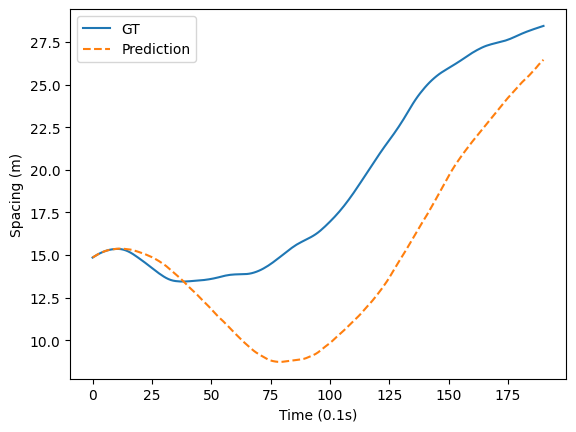

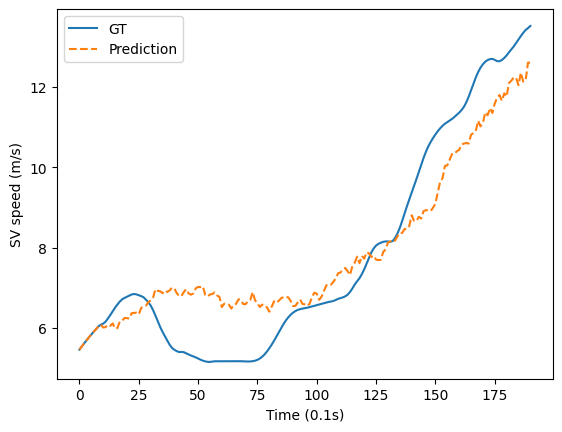

In [ ]:
spacing_obs, spacing_sim = env.data[:, 0], env.sim_data[:, 0]
sv_spd_obs, sv_spd_sim = env.data[:, 1], env.sim_data[:, 1]

# plot for one event
plt.plot(spacing_obs, label = 'GT')
plt.plot(spacing_sim, '--', label = 'Prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)');
plt.ylabel('Spacing (m)');

# speed part
plt.figure()
plt.plot(sv_spd_obs, label = 'GT')
plt.plot(sv_spd_sim, '--', label = 'Prediction')
plt.legend()
plt.xlabel(f'Time ({Ts}s)');
plt.ylabel('SV speed (m/s)');

mse_spacing = np.mean((spacing_sim - spacing_obs)**2)
print(mse_spacing)